In [102]:
import pandas as pd
import numpy as np
import datetime
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt
import pysal
import shapely
import fiona
from pyproj import Proj, transform
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [151]:
# read data
dt1 = pd.read_csv('uber-raw-data-apr14.csv')
dt2 = pd.read_csv('uber-raw-data-sep14.csv')

In [152]:
# datetime formats
fmt1 = '%m/%d/%Y %H:%M:%S'
fmt2 = '%Y-%m-%d %H:%M:%S'

# convert datetime in strings to timestamp
dt1['Date/Time'] = dt1['Date/Time'].apply(lambda x: datetime.datetime.strptime(x, fmt1))
dt2['Date/Time'] = dt2['Date/Time'].apply(lambda x: datetime.datetime.strptime(x, fmt1))

dt1['Date'] = dt1['Date/Time'].apply(lambda x: x.date())
dt2['Date'] = dt2['Date/Time'].apply(lambda x: x.date())

In [153]:
dt1.head()

,Date/Time,Lat,Lon,Base,Date
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,2014-04-01
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,2014-04-01
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,2014-04-01
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,2014-04-01
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,2014-04-01


In [154]:
dt2.head()

,Date/Time,Lat,Lon,Base,Date
0,2014-09-01 00:01:00,40.2201,-74.0021,B02512,2014-09-01
1,2014-09-01 00:01:00,40.7500,-74.0027,B02512,2014-09-01
2,2014-09-01 00:03:00,40.7559,-73.9864,B02512,2014-09-01
3,2014-09-01 00:06:00,40.7450,-73.9889,B02512,2014-09-01
4,2014-09-01 00:11:00,40.8145,-73.9444,B02512,2014-09-01


In [107]:
# read in census tracts data
#blocks = gpd.read_file('../census/nycb2010_16d/nycb2010.shp')
tracts = gpd.read_file('../census/nyct2010_16d/nyct2010.shp')

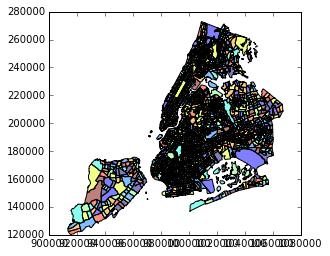

In [108]:
tracts.plot()

## Bad Route No.1 Q113

In [204]:
# define boundaries for interested bus route q113
# top_left, bottom_right
# as in format of [max_lat, min_lon, min_lat, max_long]
bus_boundaries = {'q113': [40.713765, -73.716070, 40.592908, -73.812201],
                 'b41': [40.696409, -73.902422, 40.607809, -73.991626],
                 'q65': [40.80, -73.791, 40.68, -73.88],
                 'bx15': [40.88, -73.89, 40.79, -73.97]}
nyc_boundaries = [40.917577, -73.700009, 40.477399, -74.25909]

In [156]:
# subset dt1 and dt2 within boundaries.
dt_1 = {}
dt_2 = {}

dt_1['q113'] = dt1[(dt1.Lat <= bus_boundaries['q113'][0]) & (dt1.Lat >= bus_boundaries['q113'][2])
              & (dt1.Lon <= bus_boundaries['q113'][1]) & (dt1.Lon >= bus_boundaries['q113'][3])]
dt_2['q113'] = dt2[(dt2.Lat <= bus_boundaries['q113'][0]) & (dt2.Lat >= bus_boundaries['q113'][2])
              & (dt2.Lon <= bus_boundaries['q113'][1]) & (dt2.Lon >= bus_boundaries['q113'][3])]

dt_1['bx15'] = dt1[(dt1.Lat <= bus_boundaries['bx15'][0]) & (dt1.Lat >= bus_boundaries['bx15'][2])
              & (dt1.Lon <= bus_boundaries['bx15'][1]) & (dt1.Lon >= bus_boundaries['bx15'][3])]
dt_2['bx15'] = dt2[(dt2.Lat <= bus_boundaries['bx15'][0]) & (dt2.Lat >= bus_boundaries['bx15'][2])
              & (dt2.Lon <= bus_boundaries['bx15'][1]) & (dt2.Lon >= bus_boundaries['bx15'][3])]

dt_1['b41'] = dt1[(dt1.Lat <= bus_boundaries['b41'][0]) & (dt1.Lat >= bus_boundaries['b41'][2])
              & (dt1.Lon <= bus_boundaries['b41'][1]) & (dt1.Lon >= bus_boundaries['b41'][3])]
dt_2['b41'] = dt2[(dt2.Lat <= bus_boundaries['b41'][0]) & (dt2.Lat >= bus_boundaries['b41'][2])
              & (dt2.Lon <= bus_boundaries['b41'][1]) & (dt2.Lon >= bus_boundaries['b41'][3])]

dt_1['q65'] = dt1[(dt1.Lat <= bus_boundaries['q65'][0]) & (dt1.Lat >= bus_boundaries['q65'][2])
              & (dt1.Lon <= bus_boundaries['q65'][1]) & (dt1.Lon >= bus_boundaries['q65'][3])]
dt_2['q65'] = dt2[(dt2.Lat <= bus_boundaries['q65'][0]) & (dt2.Lat >= bus_boundaries['q65'][2])
              & (dt2.Lon <= bus_boundaries['q65'][1]) & (dt2.Lon >= bus_boundaries['q65'][3])]


In [157]:
# Subset census tract data that intersect with certain bus routes
latlon_proj = fiona.crs.from_epsg(4326)
ct = {}
ct['q113'] = gpd.read_file('../ArcMap/BusRoute_CT/Q113_CT.shp').to_crs(latlon_proj)
ct['bx15'] = gpd.read_file('../ArcMap/BusRoute_CT/BX15_CT.shp').to_crs(latlon_proj)
ct['b41'] = gpd.read_file('../ArcMap/BusRoute_CT/B41_CT.shp').to_crs(latlon_proj)
ct['q65'] = gpd.read_file('../ArcMap/BusRoute_CT/Q65_CT.shp').to_crs(latlon_proj)

In [113]:
#tracts_q113.loc[1,'geometry'].exterior.coords.xy

In [158]:
def defineloc(dt,ct):
    ''' for dataframe dt and census tract file ct,
    find which BoroCT2010 code each row of dt belongs to.
    If no corresponding census tract info can be found,
    return np.nan
    '''
    dt_ct = []
    # make sure census tract file applies lat lon projection
    latlon_proj = fiona.crs.from_epsg(4326)
    ct1 = ct.to_crs(latlon_proj)
    shape = ct.geometry.map(shapely.geometry.asShape)
    
    # loop over rows in dt
    for j in range(0, len(dt)):
        sptrip = dt.iloc[j,:]
        point = shapely.geometry.Point((sptrip.Lon, sptrip.Lat))
        shape = ct1.ix[:,'geometry']
        res = ct1[shape.contains(point)]
        if len(res) != 0:
            dt_ct.append(res.iloc[0, 0])
        # if no census tract can be found:    
        else:
            dt_ct.append(0)
    return dt_ct

In [133]:
bus_boundaries.keys()

['bx15', 'q65', 'q113', 'b41']

In [160]:

for bus in bus_boundaries.keys():
    dt_1[bus]['borocode'] = defineloc(dt_1[bus], ct[bus])
    dt_2[bus]['borocode'] = defineloc(dt_2[bus], ct[bus])


/Users/macbook/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/macbook/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [218]:
res = {}
for bus in bus_boundaries.keys():
    res[bus] = pd.DataFrame([dt_1[bus][dt_1[bus]['borocode'] != 0].groupby(['Date']).count().iloc[:,1].values,
                               dt_2[bus][dt_2[bus]['borocode'] != 0].groupby(['Date']).count().iloc[:,1].values]).T
    res[bus].columns = ['april', 'september']
    res[bus]['porportion'] = res[bus]['april']/res[bus]['september']

In [220]:
res['q113']['porportion'].mean()

0.5327032512405369

In [237]:
bus_boundaries.keys()

['bx15', 'q65', 'q113', 'b41']

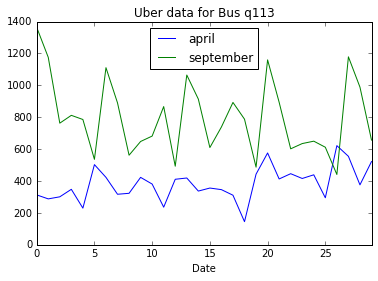

In [233]:
res['q113'].iloc[:,:2].plot()
plt.title("Uber data for Bus {}".format('q113'))
plt.xlabel('Date')
plt.savefig('uber_plot_q113')

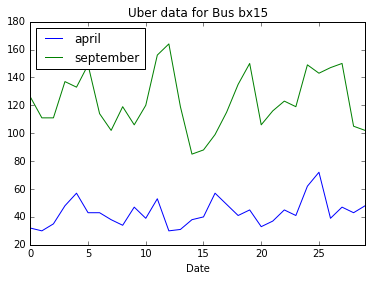

In [234]:
res['bx15'].iloc[:,:2].plot()
plt.title("Uber data for Bus {}".format('bx15'))
plt.xlabel('Date')
plt.savefig('uber_plot_bx15')

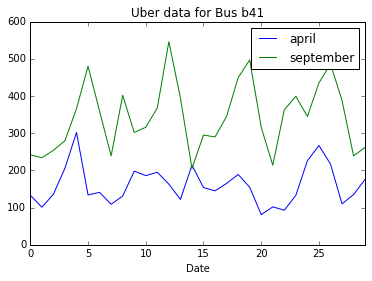

In [238]:
res['b41'].iloc[:,:2].plot()
plt.title("Uber data for Bus {}".format('b41'))
plt.xlabel('Date')
plt.savefig('uber_plot_b41')

In [236]:
res['q65'].iloc[:,:2].plot()
plt.title("Uber data for Bus {}".format('q65'))
plt.xlabel('Date')
plt.savefig('uber_plot_q65')

TypeError: Empty 'DataFrame': no numeric data to plot

# we can also look at the growth rate of uber ridership over 2015 April to 2015 September.

In [239]:
for bus in bus_boundaries.keys():
    print 'uber ridership growth rate along {} route is : {}'.format(bus, res[bus] ['porportion'].mean())

uber ridership growth rate along bx15 route is : 0.357343120562
uber ridership growth rate along q65 route is : nan
uber ridership growth rate along q113 route is : 0.532703251241
uber ridership growth rate along b41 route is : 0.491595413616
